# **Assignment 02 - Mini-project (report and code)**

## a1919301 Hansi Cooray

#### Install Libraries

In [1]:
!pip install stackapi

In [2]:
pip install lxml

In [3]:
pip install wordcloud matplotlib

### Import Libraries

In [4]:
import stackapi
import pandas as pd
import time
from datetime import datetime
import html
from bs4 import BeautifulSoup
import traceback
import os
import re # For regular expressions (punctuation/symbol removal)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
import openpyxl

In [5]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 1. Data Extraction - Manual Pagination

   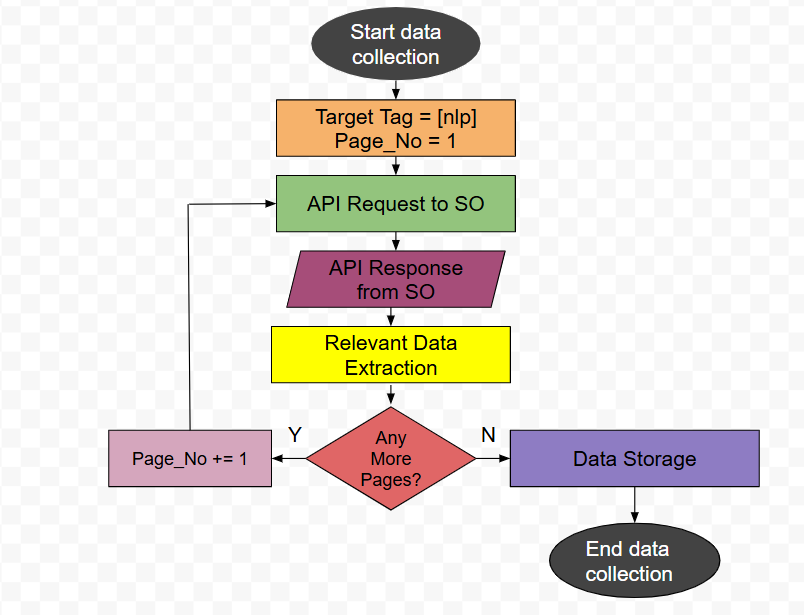

In [ ]:
"""
# Setting Maximum pages to fetch data
MAX_PAGES_FETCH = 250
ITEMS_PER_PAGE = 100 # Max allowed by API

# Use API to get data from stackoverflow
STACK_API_KEY = 'rl_QuiS69pcJuGHpJ1qEjQARQa2V'
# --- END API KEY CONFIGURATION ---


OUTPUT_FILENAME = 'stackoverflow_nlp_data.xlsx'

# Helper Function to Clean HTML
def clean_html(html_content):
    #Uses BeautifulSoup to remove HTML tags from a string.
    if html_content is None:
        return ""
    try:
        soup = BeautifulSoup(html_content, 'lxml')
        text = soup.get_text(separator=' ', strip=True)
        # Additional check and unescape for entities that might remain
        text = html.unescape(text)
        return text
    except Exception as e:
        try:
             # Try basic unescape even if soup failed
             return html.unescape(str(html_content))
        except:
             return str(html_content)


# Initialize StackAPI
print("Initializing Stack API connection...")
try:
    if STACK_API_KEY:
        print("Using provided API Key.")
        SITE = stackapi.StackAPI('stackoverflow', key=STACK_API_KEY)
    else:
        print("WARNING: No API Key provided. Request quota will be severely limited (~300 requests/day).")
        print("Fetching large amounts of data will likely fail without a key.")
        SITE = stackapi.StackAPI('stackoverflow')
    SITE.page_size = ITEMS_PER_PAGE
    print(f"Site: {SITE.site.name}, Page Size: {SITE.page_size}")
except Exception as e:
    print(f"Fatal Error: Error initializing StackAPI: {e}")
    exit()

# ============================================================
# PART 1: Fetch ALL posts tagged as NLP - Manual Pagination
# ============================================================
print(f"\n--- Starting PART 1: Fetching ALL questions tagged [nlp] (Manual Pagination) ---")
all_posts_raw_data = []
request_filter_withbody = 'withbody' # Standard filter including body
current_page = 1
fetch_count_this_run = 0
max_pages_manual = MAX_PAGES_FETCH # Use the config
consecutive_fetch_errors = 0
max_consecutive_fetch_errors = 5 # Stop if fetch fails repeatedly

while current_page <= max_pages_manual:
    if consecutive_fetch_errors >= max_consecutive_fetch_errors:
        print(f"Stopping PART 1 fetch due to {max_consecutive_fetch_errors} consecutive page fetch errors.")
        break

    print(f"Fetching page {current_page}/{max_pages_manual}...")
    try:
        # Fetch one page at a time using the 'page' parameter
        response = SITE.fetch('questions',
                              tagged='nlp',
                              sort='creation',
                              order='desc',
                              filter=request_filter_withbody,
                              page=current_page, # Fetch specific page number
                              pagesize=ITEMS_PER_PAGE) # Ensure pagesize is set

        items = response.get('items', [])
        has_more = response.get('has_more', False)
        quota_rem = response.get('quota_remaining', 'N/A')

        if items:
            all_posts_raw_data.extend(items)
            fetch_count_this_run += len(items)
            print(f"  Fetched {len(items)} items from page {current_page}. Total fetched: {len(all_posts_raw_data)}. Quota remaining: {quota_rem}")
            consecutive_fetch_errors = 0 # Reset error count on success
        else:
            print(f"  No items returned for page {current_page}. Stopping.")
            break # Stop if a page returns no items

        # Check if API says there are more pages
        if not has_more:
            print(f"  API indicated no more items ('has_more': False). Stopping fetch.")
            break # Exit the loop if API says no more data

        current_page += 1 # Increment to fetch the next page
        # Add a small delay between page fetches to be polite/avoid rate limits
        time.sleep(1.0) # Wait 1 second between page requests

    except stackapi.StackAPIError as e:
        print(f"  ERROR: StackAPI Error fetching page {current_page}: Code {e.code} - {e.message}")
        consecutive_fetch_errors += 1
        if e.code == 502 and hasattr(e, 'message') and 'backoff' in e.message.lower():
             try:
                 wait_time = int(e.message.split('backoff=')[1].split()[0]) + 2
                 print(f"    API backoff requested. Waiting {wait_time} seconds...")
                 time.sleep(wait_time)
             except Exception as e_parse:
                 print(f"    Could not parse backoff time, waiting default 15s. Parse Error: {e_parse}")
                 time.sleep(15)
        else:
             print(f"    Non-backoff API error on page {current_page}. Waiting longer (15s) before potentially retrying next page or stopping...")
             time.sleep(15)
    except Exception as e_gen:
        print(f"  ERROR: Non-API Error fetching page {current_page}: {e_gen}")
        traceback.print_exc()
        consecutive_fetch_errors += 1
        print(f"    Waiting 15s before potentially retrying next page or stopping...")
        time.sleep(15)


print(f"\nPART 1: Finished fetching loop.")
print(f"PART 1: Fetched a total of {len(all_posts_raw_data)} raw posts tagged [nlp].")


# Process PART 1 Data (Clean HTML)
print("PART 1: Processing fetched posts (cleaning descriptions)...")
# Keep the existing processing loop from the previous script
all_posts_processed = []
if all_posts_raw_data:
    # match the structure from the full script
     for i, q in enumerate(all_posts_raw_data):
        if (i + 1) % 500 == 0: # Print progress every 500 posts
            print(f"  Processing post {i + 1}/{len(all_posts_raw_data)}...")
        # Basic check for essential fields
        if 'title' in q and 'tags' in q:
            html_body = q.get('body', '')
            cleaned_desc = clean_html(html_body) if html_body else ''

            all_posts_processed.append({
                'question_id': q.get('question_id', f'missing_id_{i}'),
                'title': html.unescape(q['title']),
                'description': cleaned_desc,
                'tags': q.get('tags', []),
                'answer_count': q.get('answer_count', 0),
                'view_count': q.get('view_count', 0),
                'has_accepted_answer': 'accepted_answer_id' in q,
                'creation_date': datetime.fromtimestamp(q.get('creation_date', 0)),
            })
        else:
            print(f"  Skipping raw post at index {i} due to missing title or tags.")
     print(f"PART 1: Finished processing {len(all_posts_processed)} posts.")

else:
    print("PART 1: No raw posts data was fetched or available.")


# ============================================================
# PART 2: Fetch posts with an Accepted Answer
# ============================================================
# Reuse data from Part 1
print(f"\n--- Starting PART 2: Identifying questions with Accepted Answers from PART 1 data ---")
accepted_posts_raw_data = [] # Will hold dicts including 'accepted_answer_id'
accepted_answer_ids_to_fetch = set()

# Filter the already fetched data instead of making a new large API call
if all_posts_raw_data:
    for q in all_posts_raw_data:
        # Ensure required fields for this part exist
         if 'accepted_answer_id' in q and 'question_id' in q and 'title' in q and 'body' in q and 'tags' in q:
             accepted_posts_raw_data.append({
                 'question_id': q['question_id'],
                 'title': html.unescape(q['title']),
                 'description_html': q['body'],
                 'tags': q['tags'],
                 'accepted_answer_id': q['accepted_answer_id'] # Key field
             })
             accepted_answer_ids_to_fetch.add(str(q['accepted_answer_id'])) # Add ID for answer fetching

    print(f"PART 2: Identified {len(accepted_posts_raw_data)} posts with accepted answers from initial fetch.")
    print(f"PART 2: Identified {len(accepted_answer_ids_to_fetch)} unique accepted answer IDs to fetch bodies for.")

else:
    print("PART 2: Cannot proceed as PART 1 fetch failed or returned no data.")


# Fetch Accepted Answer Bodies (For PART 2)
accepted_answers_html = {} # Dictionary to store {answer_id: html_body}
if accepted_answer_ids_to_fetch:
    print("PART 2: Fetching accepted answer bodies...")
    batch_size = 80 # Safe batch size
    unique_answer_ids_list = list(accepted_answer_ids_to_fetch)
    total_batches = (len(unique_answer_ids_list) + batch_size - 1) // batch_size
    request_delay = 1.5 # Increased base delay
    consecutive_errors = 0
    max_consecutive_errors = 5 # Stop if too many batches fail in a row

    for i in range(0, len(unique_answer_ids_list), batch_size):
        if consecutive_errors >= max_consecutive_errors:
             print(f"STOPPING answer fetch due to {max_consecutive_errors} consecutive batch errors.")
             break # Stop fetching answers if it's failing repeatedly

        batch_ids = unique_answer_ids_list[i:i + batch_size]
        ids_string = ';'.join(batch_ids)
        current_batch_num = (i // batch_size) + 1
        print(f"  Fetching answer batch {current_batch_num}/{total_batches} ({len(batch_ids)} IDs)...")

        try:
            answers_response = SITE.fetch('answers/{ids}',
                                          ids=ids_string,
                                          filter=request_filter_withbody)

            # Debugging API response for answers:
            # print(f"DEBUG (Answer Batch {current_batch_num}): Quota Remaining: {answers_response.get('quota_remaining', 'N/A')}, Has More: {answers_response.get('has_more', 'N/A')}")

            answers = answers_response.get('items', [])
            fetched_this_batch = 0
            for answer in answers:
                 if 'answer_id' in answer and 'body' in answer:
                     accepted_answers_html[answer['answer_id']] = answer['body']
                     fetched_this_batch += 1
            print(f"    Successfully fetched {fetched_this_batch} bodies in batch {current_batch_num}.")
            consecutive_errors = 0 # Reset error count on success
            # Add a delay AFTER a successful request
            time.sleep(request_delay)

        except stackapi.StackAPIError as e_ans:
             print(f"  ERROR: StackAPI Error fetching answers batch {current_batch_num}: Code {e_ans.code} - {e_ans.message}")
             consecutive_errors += 1
             if e_ans.code == 502 and hasattr(e_ans, 'message') and 'backoff' in e_ans.message.lower():
                 try:
                     wait_time = int(e_ans.message.split('backoff=')[1].split()[0]) + 2 # Extract backoff seconds
                     print(f"    API backoff requested. Waiting {wait_time} seconds...")
                     time.sleep(wait_time)
                 except Exception as e_parse:
                     print(f"    Could not parse backoff time, waiting default 10s. Parse Error: {e_parse}")
                     time.sleep(10)
             else:
                  print(f"    Non-backoff API error on batch {current_batch_num}. Waiting longer (10s) before next attempt...")
                  time.sleep(10)
        except Exception as e_gen:
            print(f"  ERROR: Non-API Error fetching answers batch {current_batch_num}: {e_gen}")
            traceback.print_exc()
            consecutive_errors += 1
            print(f"    Waiting 10s before next attempt...")
            time.sleep(10)


    print(f"PART 2: Finished fetching attempts. Successfully obtained HTML bodies for {len(accepted_answers_html)} accepted answers out of {len(unique_answer_ids_list)} unique IDs.")
    if consecutive_errors >= max_consecutive_errors:
         print(f"WARNING: Answer fetching stopped early due to repeated errors.")

else:
    # This condition met if Part 1 had data, but none had accepted_answer_id
    if all_posts_raw_data:
        print("PART 2: No accepted answer IDs were identified in the initial data. Skipping answer body fetch.")
    else:
        print("PART 2: Skipping answer fetch because PART 1 data is missing.")


# Process PART 2 Data (Combine, Clean HTML Q&A)
print("PART 2: Processing posts with accepted answers (cleaning descriptions and answers)...")
accepted_posts_processed = []
if accepted_posts_raw_data: # Check if we identified posts with accepted answers
    skipped_count = 0
    found_answer_count = 0
    for i, item in enumerate(accepted_posts_raw_data):
        if (i + 1) % 500 == 0:
             print(f"  Processing accepted post {i + 1}/{len(accepted_posts_raw_data)}...")

        accepted_answer_html_body = accepted_answers_html.get(item['accepted_answer_id'])

        if accepted_answer_html_body: # Process only if answer body was actually fetched
            cleaned_desc = clean_html(item['description_html'])
            cleaned_answer = clean_html(accepted_answer_html_body)
            found_answer_count +=1

            accepted_posts_processed.append({
                'question_id': item['question_id'],
                'title': item['title'],
                'description': cleaned_desc,
                'tags': item['tags'],
                'accepted_answer': cleaned_answer
            })
        else:
            skipped_count += 1 # Count how many accepted answers couldn't be fetched

    print(f"PART 2: Finished processing.")
    print(f"  - Included {len(accepted_posts_processed)} posts where accepted answer body was successfully fetched and processed.")
    if skipped_count > 0:
         print(f"  - Skipped {skipped_count} posts because their accepted answer body could not be fetched (due to errors or stopping early).")
else:
     print("PART 2: No raw posts identified as having accepted answers to process.")


# ============================================================
# PART 3: Create DataFrames and Save to Excel Tabs
# ============================================================
print(f"\n--- Starting PART 3: Preparing DataFrames and Saving to {OUTPUT_FILENAME} ---")

# Create DataFrame for ALL Posts (Tab 1)
if all_posts_processed:
    df_all = pd.DataFrame(all_posts_processed)
    df_all['tags_str'] = df_all['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
    # Select final columns for this sheet, placing key identifying info first
    df_all_final = df_all[['question_id', 'title', 'description', 'tags_str', 'answer_count', 'view_count', 'has_accepted_answer', 'creation_date']].copy()
    print(f"Created DataFrame for 'All_NLP_Posts' with {len(df_all_final)} rows.")
else:
    df_all_final = pd.DataFrame()
    print("No data processed for 'All_NLP_Posts'. Created empty DataFrame.")


# Create DataFrame for Accepted Answer Posts (Tab 2)
if accepted_posts_processed:
    df_accepted = pd.DataFrame(accepted_posts_processed)
    df_accepted['tags_str'] = df_accepted['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
     # Select final columns, placing key identifying information first
    df_accepted_final = df_accepted[['question_id', 'title', 'description', 'tags_str', 'accepted_answer']].copy()
    print(f"Created DataFrame for 'Accepted_Answer_Posts' with {len(df_accepted_final)} rows.")
else:
    df_accepted_final = pd.DataFrame()
    print("No data processed for 'Accepted_Answer_Posts'. Created empty DataFrame.")

# Save to Excel
if not df_all_final.empty or not df_accepted_final.empty:
    print(f"Attempting to save DataFrames to sheets in {OUTPUT_FILENAME}...")
    try:
        # Ensure file isn't locked by another process before writing
        if os.path.exists(OUTPUT_FILENAME):
             print(f"WARNING: File '{OUTPUT_FILENAME}' already exists. It will be overwritten.")
             # Simple check: Try to open for append access to see if it's locked
             try:
                 f = open(OUTPUT_FILENAME, 'a')
                 f.close()
             except IOError as e:
                 print(f"FATAL ERROR: Cannot write to '{OUTPUT_FILENAME}'. Is it open in Excel?")
                 print(f"  Error details: {e}")
                 print("Please close the file and run the script again.")
                 exit() # Stop if file is locked

        with pd.ExcelWriter(OUTPUT_FILENAME, engine='openpyxl') as writer:
            if not df_all_final.empty:
                 df_all_final.to_excel(writer, sheet_name='All_NLP_Posts', index=False)
                 print(f"  - Saved 'All_NLP_Posts' ({len(df_all_final)} rows)")
            else:
                 print("  - Skipped writing empty 'All_NLP_Posts' sheet.")

            if not df_accepted_final.empty:
                 df_accepted_final.to_excel(writer, sheet_name='Accepted_Answer_Posts', index=False)
                 print(f"  - Saved 'Accepted_Answer_Posts' ({len(df_accepted_final)} rows)")
            else:
                 print("  - Skipped writing empty 'Accepted_Answer_Posts' sheet.")
        print("Excel file write process completed successfully.")

    except Exception as e:
        print(f"\nFATAL ERROR saving data to Excel file: {e}")
        traceback.print_exc()
else:
    print("\nBoth datasets are empty. Nothing to save to Excel.")


print("\nScript finished.")

"""

Initializing Stack API connection...
Using provided API Key.
Fatal Error: Error initializing StackAPI: 'StackAPI' object has no attribute 'site'

--- Starting PART 1: Fetching ALL questions tagged [nlp] (Manual Pagination) ---
Fetching page 1/250...
  Fetched 500 items from page 1. Total fetched: 500. Quota remaining: 9948
Fetching page 2/250...
  Fetched 500 items from page 2. Total fetched: 1000. Quota remaining: 9947
Fetching page 3/250...
  Fetched 500 items from page 3. Total fetched: 1500. Quota remaining: 9941
Fetching page 4/250...
  Fetched 500 items from page 4. Total fetched: 2000. Quota remaining: 9937
Fetching page 5/250...
  Fetched 500 items from page 5. Total fetched: 2500. Quota remaining: 9932
Fetching page 6/250...
  Fetched 500 items from page 6. Total fetched: 3000. Quota remaining: 9927
Fetching page 7/250...
  Fetched 500 items from page 7. Total fetched: 3500. Quota remaining: 9920
Fetching page 8/250...
  Fetched 500 items from page 8. Total fetched: 4000. Quot

#### Cleaning Description- Remove Codes

In [6]:
EXCEL_FILE_PATH = '/content/stackoverflow_nlp_data.xlsx' # excel dataset filepath

In [7]:
NEW_SHEET_NAME = 'Cleaned_Titles_Descriptions'
TITLE_COLUMN = 'title'
DESCRIPTION_COLUMN = 'description'

sheet_identifier = 1  # Specify the sheet
df = pd.read_excel(EXCEL_FILE_PATH, sheet_name=sheet_identifier) # Convert the dataset into a dataframe

# Function to Remove Code Snippets
def remove_code_snippets(text):
    """Removes content within <pre><code>...</code> and <code>...</code> tags."""
    if not isinstance(text, str):
        return '' # Return empty string for NaN or non-string types

    # Remove multi-line code blocks first (<pre><code>...</code></pre>)
    text = re.sub(r'<pre><code>.*?</code></pre>', '', text, flags=re.DOTALL | re.IGNORECASE)

    # Remove inline code blocks (<code>...</code>)
    text = re.sub(r'<code>.*?</code>', '', text, flags=re.IGNORECASE)

    # Clean up potential extra whitespace left after removal
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Main Logic
if df is not None:
   # 1. Select the original title column
    if TITLE_COLUMN in df.columns:
        titles = df[TITLE_COLUMN].fillna('') # Handle missing titles

    else:
        print(f"Error: Title column '{TITLE_COLUMN}' not found in DataFrame.")
        titles = None

    # 2. Select and clean the description column
    if DESCRIPTION_COLUMN in df.columns:
        # Apply the cleaning function
        cleaned_descriptions = df[DESCRIPTION_COLUMN].fillna('').apply(remove_code_snippets)
    else:
        print(f"Error: Description column '{DESCRIPTION_COLUMN}' not found in DataFrame.")
        cleaned_descriptions = None

    # 3. Proceed only if both columns were found
    if titles is not None and cleaned_descriptions is not None:
        # 4. Create a new DataFrame with only these two columns
        df_to_write = pd.DataFrame({
            'title': titles,
            'description_no_code': cleaned_descriptions
        })
        print("\nCreated new DataFrame with titles and cleaned descriptions.")
        print("Sample data to be written:")
        print(df_to_write.head())

        # 5. Write this new DataFrame to a new sheet in the existing Excel file
        with pd.ExcelWriter(EXCEL_FILE_PATH,
                                engine='openpyxl',
                                mode='a', # Append mode to add sheets
                                if_sheet_exists='replace') as writer: # Replace sheet if it exists
                df_to_write.to_excel(writer, sheet_name=NEW_SHEET_NAME, index=False)
        print("Successfully wrote data to the new sheet.")

    else:
        print("\nCannot proceed with writing to Excel as one or both required columns were not found.")

else:
    print("\nOriginal DataFrame 'df' is not loaded. Cannot perform operations.")


Created new DataFrame with titles and cleaned descriptions.
Sample data to be written:
                                               title  \
0  Trouble getting importing gensim to work in colab   
1        Store images instead of showing in a server   
2  Presidio with Langchain Experimental does not ...   
3          OpenNLP POSTaggerME and ChunkerME synergy   
4                        word/ sentence similarities   

                                 description_no_code  
0  I am trying to import gensim into colab. !pip ...  
1  I am running the code found on this [site][1] ...  
2  I am using presidio/langchain_experimental to ...  
3  I'm trying to use the OpenNLP chunking API to ...  
4  I am trying to find if a given word/ set of wo...  
Successfully wrote data to the new sheet.


#### Overview of Data - Statisical Details

In [9]:
import pandas as pd

# Load Excel file
file_path = '/content/stackoverflow_nlp_data.xlsx'
stats = pd.read_excel(file_path, sheet_name=0)

# Convert creation_date to datetime if not already
stats['creation_date'] = pd.to_datetime(stats['creation_date'])

# 1. Number of posts with no answers
no_answer_count = stats[stats['answer_count'] == 0].shape[0]

# 2. Average view count
average_views = stats['view_count'].mean()

# 3. Topics (tags) without answers
tags_no_answers = stats[stats['answer_count'] == 0]['tags_str'].value_counts()


# Statistical details
print("Number of posts with no answers:", no_answer_count)
print("Average view count:", average_views)
print("\nTop tags with no answers:")
print(tags_no_answers.head(10))  # top 10 tags without answers


Number of posts with no answers: 13082
Average view count: 1305.9045087719298

Top tags with no answers:
tags_str
python, nlp                                     326
python, nlp, spacy                              180
python, nlp, nltk                               153
nlp                                             146
nlp, spacy                                       78
python, pandas, nlp                              75
r, nlp                                           70
python, nlp, spacy, named-entity-recognition     50
nlp, spacy, named-entity-recognition             40
python, python-3.x, nlp, nltk                    40
Name: count, dtype: int64


In [10]:
# Creating a dataframe contains the data with title and cleaned description(no codes) for the categorization.
sheet_identifier = 2  # Specify the sheet
data = pd.read_excel(EXCEL_FILE_PATH, sheet_name=sheet_identifier) # Convert the dataset into a dataframe


In [11]:
data['accepeted_answer'] = df['accepted_answer']
data['tags']= df['tags_str']

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21083 entries, 0 to 21082
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                21083 non-null  object
 1   description_no_code  21083 non-null  object
 2   accepeted_answer     21083 non-null  object
 3   tags                 21083 non-null  object
dtypes: object(4)
memory usage: 659.0+ KB


In [13]:
data.head(1)

,title,description_no_code,accepeted_answer,tags
0,Trouble getting importing gensim to work in colab,I am trying to import gensim into colab. !pip ...,You have to restart the session for the underl...,"numpy, nlp, dependencies, google-colaboratory,..."


## 2. Text Pre-Processing

    1. Remove HTML tags (Handles potential HTML even if not in every row).
    2. Remove punctuation, special symbols, and numbers (keeps only letters and spaces).
    3. Convert text to lowercase.
    4. Tokenize the text into words.
    5. Remove standard English stop words.
    6. Keep only purely alphabetic tokens.
    Returns a list of processed tokens.

#### Identify frequent terms(except English stopwords) - For customize stop word


Tokenizing and counting word frequencies (Top 50)...
Top words found: ['0', '1', 'text', 'model', '2', 'import', 'word', 'words', 'data', 'self', 'n', 'using', '3', 'nlp', 'like', 'print', 'spacy', 'list', 'code', 'x', 'sentence', 'nan', 'file', 'output', 'get', 'want', 'return', 'true', 'python', '4', 'error', '5', 'use', 'would', 'df', 'line', 'input', 'def', 'one', 'token', 'example', 'py', 'c', 'string', 'tokenizer', 'sentences', 'doc', 'tf', 'trying', 'dataset']

Generating plot...


<ipython-input-14-e31269875e5c>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts, y=top_words, palette='viridis')


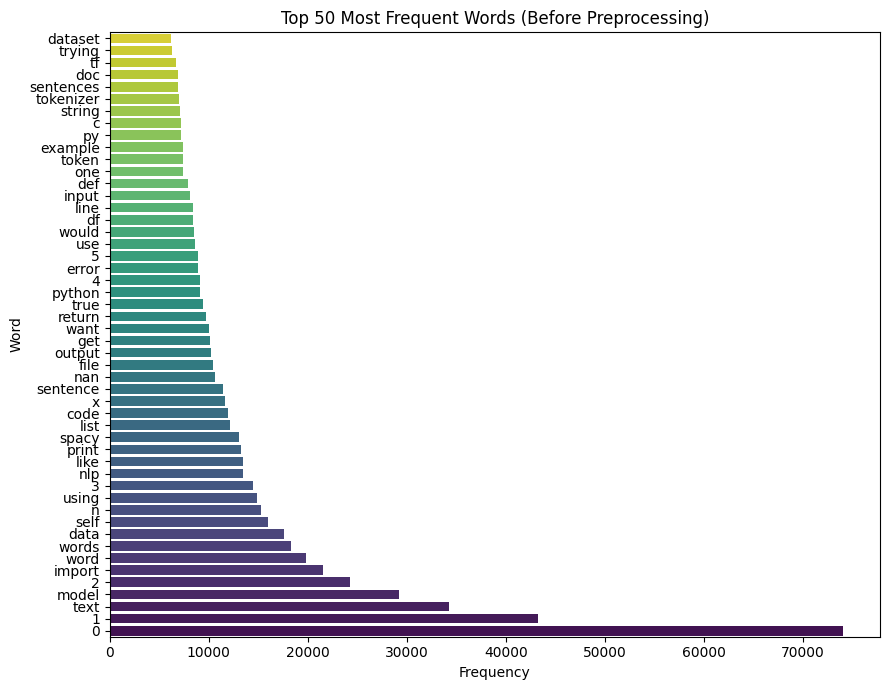

In [14]:
stop_words = set(stopwords.words('english'))
NUM_TOP_WORDS = 50
titles_raw = data['title'].astype(str).fillna('')
descriptions_raw = data['description_no_code'].astype(str).fillna('')

# Combine text from both columns row-wise
combined_series_raw = titles_raw + ' ' + descriptions_raw

# Join all combined strings into one large text blob
all_combined_raw_text = ' '.join(combined_series_raw)


#Basic Tokenization and Frequency Count
if not all_combined_raw_text.strip():
    print("\nError: No text available in raw titles/descriptions.")
else:
    print(f"\nTokenizing and counting word frequencies (Top {NUM_TOP_WORDS})...")
    # Convert to lowercase
    text_lower = all_combined_raw_text.lower()

    # Use regex to find sequences of word characters ignoring punctuation and symbols
    words_raw = re.findall(r'\b\w+\b', text_lower)

    #filter stopwords-english
    words_filtered = [word for word in words_raw if word not in stop_words]

    # Count frequencies of filtered words
    word_counts = Counter(words_filtered)

    # Get the most common words from the filtered words
    most_common_words = word_counts.most_common(NUM_TOP_WORDS)

    # Separate words and their counts for plotting
    top_words = [word for word, count in most_common_words]
    top_counts = [count for word, count in most_common_words]

    print("Top words found:", top_words)

    # Plotting the Frequencies
    print("\nGenerating plot...")
    plt.figure(figsize=(9, 7))

    # Use seaborn for potentially nicer aesthetics
    sns.barplot(x=top_counts, y=top_words, palette='viridis')

    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.title(f"Top {NUM_TOP_WORDS} Most Frequent Words (Before Preprocessing)")
    plt.gca().invert_yaxis() # Display the most frequent word at the top
    plt.tight_layout() # Adjust layout
    plt.show()

In [16]:
# List of columns containing text to be pre-processed
TEXT_COLUMNS_TO_PROCESS = ['title', 'description_no_code','accepeted_answer']

# Get the set of English stop words
standard_stopwords = set(stopwords.words('english'))

# Some stopwords were identified after analysing the frequent word count and word cloud.
custom_stopwords = {
    # Common English Fillers/Pronouns/Verbs which are not presented in MLTK
    'im', 'ive', 'id', 'like', 'see', 'look', 'know', 'find', 'want', 'need',
    'would', 'could', 'should', 'must', 'might', 'may', 'also', 'even', 'just',
    'really', 'seems', 'however', 'based', 'actually', 'basically', 'specific',
    'instead', 'since', 'well', 'perhaps', 'maybe', 'able', 'tried', 'tryna',
    'gonna', 'got', 'one', 'two', 'first', 'second', 'another', 'other',
    'much', 'many', 'lot', 'bit', 'something', 'anything', 'nothing', 'someone',
    'anyone', 'noone', 'every', 'without', 'within', 'among', 'around',

    # Stack Overflow Terms
    'please', 'thanks', 'thank', 'sorry', 'question', 'answer', 'post',
    'problem',
     'following', 'related', 'stack', 'overflow',
    'appreciate', 'advice', 'suggestion', 'regards', 'hi', 'hello', 'hey',

    # Generic Programming words
    'code', 'function', 'method', 'class', 'variable', 'parameter', 'argument',
    'input', 'output', 'result',
    'print', 'return', 'loop', 'list', 'dict', 'dictionary', 'array', 'set', 'tuple',
    'string', 'integer', 'float', 'boolean', 'true', 'false', 'none', 'null', 'nan',
    'variable', 'object', 'instance', 'script', 'program',
    'def', 'self', 'cls', 'lambda', 'try', 'except', 'finally', 'with',

    #  Nouns/Adjectives
    'time', 'number', 'name', 'type', 'kind', 'part', 'thing', 'line',
    'new', 'different', 'same', 'similar', 'various', 'certain', 'current',
    'possible', 'available', 'actual', 'general', 'simple', 'basic',

    # URL fragments identified
    'http', 'https', 'www', 'com', 'org', 'io', 'github', 'html', 'url',
    'usr', 'lib', 'local', 'dist', 'packages', 'py',
    'et', 'al', 'eg', 'ie', 'etc', 'fig', 'image', 'png', 'jpg',
    'b', 'c', 'e', 'f', 'g', 'k', 'n', 'p', 'q', 'r', 't', 'v', 'w', 'x', 'y', 'z' # Single letters (keep 'a' and 'i')
}



In [17]:
MAX_WORD_LENGTH = 20 #This is to ommit meaningless words after pre-processing
all_stopwords = standard_stopwords.union(custom_stopwords)

# The Pre-processing Function
def preprocess_text(text):

    if not isinstance(text, str):
        return [] # Return empty list for non-string input

    # 1. Remove HTML tags (using BeautifulSoup)- This is for further preprocessing . The dataset is created by removing HTML tags
    soup = BeautifulSoup(text, "lxml")
    text = soup.get_text()

    # 2. Remove punctuation, special symbols, and numbers and replacing anything not letter with a space.
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Tokenize into words
    tokens = word_tokenize(text)

    # 5. Remove stop words & 6. Keep only alphabetic tokens
    processed_tokens = [
        word for word in tokens
        if word.isalpha() # Keep only alphabetic words
        and word not in all_stopwords  # Remove stop words
        and len(word) <= MAX_WORD_LENGTH  # Remove words longer than threshold
    ]


    return processed_tokens


In [18]:
#Apply process function to title, discription and accepted_answer column
for col in TEXT_COLUMNS_TO_PROCESS:
    if col in data.columns:
        new_col_name = f"{col}_processed_tokens" # eg- 'title_processed_tokens'
        print(f"Processing column: '{col}' -> Creating '{new_col_name}'")
        data[new_col_name] = data[col].apply(preprocess_text)
data.info()

Processing column: 'title' -> Creating 'title_processed_tokens'
Processing column: 'description_no_code' -> Creating 'description_no_code_processed_tokens'
Processing column: 'accepeted_answer' -> Creating 'accepeted_answer_processed_tokens'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21083 entries, 0 to 21082
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   title                                 21083 non-null  object
 1   description_no_code                   21083 non-null  object
 2   accepeted_answer                      21083 non-null  object
 3   tags                                  21083 non-null  object
 4   title_processed_tokens                21083 non-null  object
 5   description_no_code_processed_tokens  21083 non-null  object
 6   accepeted_answer_processed_tokens     21083 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [19]:
data.head(1)

,title,description_no_code,accepeted_answer,tags,title_processed_tokens,description_no_code_processed_tokens,accepeted_answer_processed_tokens
0,Trouble getting importing gensim to work in colab,I am trying to import gensim into colab. !pip ...,You have to restart the session for the underl...,"numpy, nlp, dependencies, google-colaboratory,...","[trouble, getting, importing, gensim, work, co...","[trying, import, gensim, colab, pip, install, ...","[restart, session, underlying, runtime, notice..."


In [20]:
# Initialize an empty dictionary to build the new DataFrame - Processed version containing the 4 columns.
processed_data = {}

# Include tags_str if it exists in the original DataFrame
if 'tags' in data.columns:
    processed_data['tags'] = data['tags']
else:
    print("Warning: 'tags' column not found in original DataFrame.")

# Iterate through the original text columns that were processed
for col in TEXT_COLUMNS_TO_PROCESS:
    processed_token_col = f"{col}_processed_tokens" # Name of the column with token lists
    new_string_col = f"{col}" # Name for the new column with joined strings

    if processed_token_col in data.columns:
        processed_data[new_string_col] = data[processed_token_col].apply(' '.join)
    else:
        print(f"Warning: Processed token column '{processed_token_col}' not found. Skipping for new DataFrame.")

# Create the new DataFrame from the dictionary
df_processed = pd.DataFrame(processed_data)

In [21]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21083 entries, 0 to 21082
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tags                 21083 non-null  object
 1   title                21083 non-null  object
 2   description_no_code  21083 non-null  object
 3   accepeted_answer     21083 non-null  object
dtypes: object(4)
memory usage: 659.0+ KB


In [22]:
df_processed.head(2)

,tags,title,description_no_code,accepeted_answer
0,"numpy, nlp, dependencies, google-colaboratory,...",trouble getting importing gensim work colab,trying import gensim colab pip install gensim ...,restart session underlying runtime notice pack...
1,"python, nlp, large-language-model",store images showing server,running found site server store images showing...,test checked source uses matplotlib remove sho...


## 3. Data Visualization




In [23]:
titles_text = df_processed['title'].astype(str).fillna('')
descriptions_text = df_processed['description_no_code'].astype(str).fillna('')

In [24]:
combined_series = titles_text + ' ' + descriptions_text #Combine ttitle_text and Description_text

In [25]:
# Join all combined strings into one large text blob
all_combined_text = ' '.join(combined_series)

In [26]:
wordcloud = WordCloud(width=1000, # Width of the image
                              height=500, # Height of the image
                              background_color='white', # Background color
                              max_words=150, # Max number of words to display
                              collocations=False, # Disable grouping of words (e.g., "New York")
                              random_state=42 # For reproducible layout
                             )

In [27]:
wordcloud.generate(all_combined_text)

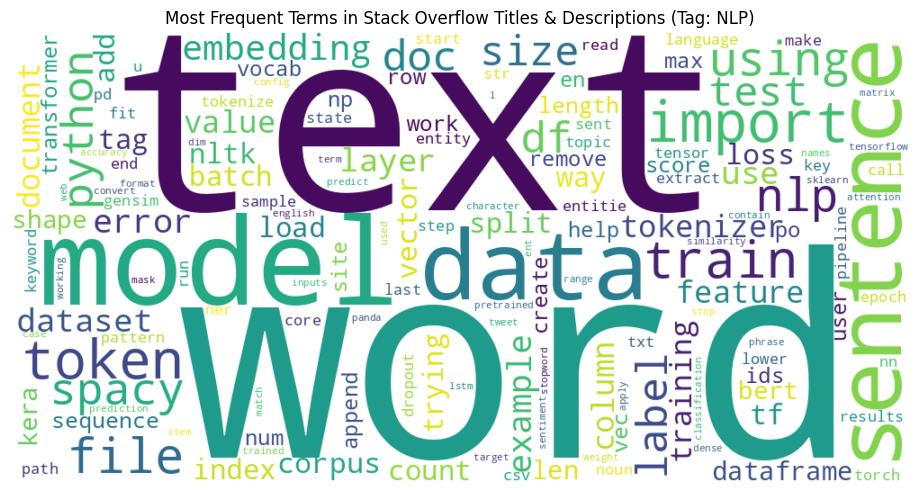

In [28]:
plt.figure(figsize=(9, 6)) # Set the figure size
plt.imshow(wordcloud, interpolation='bilinear') # Display the image
plt.axis("off") # Hide the axes
plt.title("Most Frequent Terms in Stack Overflow Titles & Descriptions (Tag: NLP)") # Set title
plt.tight_layout(pad=0) # Adjust layout
plt.show() # Show the plot

## 4. Categorisation of the NLP-tagged posts

#### Define Categories

1. Library Categories - 6
2. Task Categories - 14
3. Specific Check Categories - 4
4. Fallback/General Category -1






In [29]:
# Category: Library Specific
LIBRARY_KEYWORDS = {
    'Library - spaCy': r'\bspacy\b',
    'Library - NLTK': r'\bnltk\b',
    'Library - Transformers/HF': r'\b(transformers|huggingface|hugging face|bert|gpt|distilbert|roberta|t5|bart)\b',
    'Library - Gensim': r'\bgensim\b',
    'Library - Scikit-learn': r'\b(scikit learn|sklearn)\b',
    'Library - Keras/TF/PyTorch': r'\b(keras|tensorflow|tf|pytorch)\b',

}

In [30]:
# Category: Specific NLP Tasks
TASK_KEYWORDS = {
    'Task - Classification': r'\b(classify|classification|categorization|classifier)\b',
    'Task - NER': r'\b(ner|named entity recognition|entity extraction)\b',
    'Task - Similarity/Distance': r'\b(similarity|distance|cosine|jaccard|levenshtein|embedding distance)\b',
    'Task - Embeddings/Vectorization': r'\b(embedding|vectorize|vectorization|word2vec|doc2vec|glove|fasttext|tf idf|tfidf|countvectorizer)\b',
    'Task - Tokenization': r'\b(tokenize|tokenizer|tokenization|segmentation|word split)\b',
    'Task - Preprocessing/Cleaning': r'\b(preprocess|preprocessing|clean|cleaning|normalize|normalization|remove punctuation|remove stop words)\b',
    'Task - Stemming/Lemmatization': r'\b(stemming|stemmer|lemmatize|lemmatization|lemmatizer)\b',
    'Task - Topic Modeling': r'\b(topic model|lda|latent dirichlet allocation|nmf)\b',
    'Task - Summarization': r'\b(summarize|summarization|summary)\b',
    'Task - Question Answering': r'\b(question answer|qa)\b',
    'Task - Language Model': r'\b(language model|lm|language modeling)\b',
    'Task - Sentiment Analysis': r'\b(sentiment)\b',
    'Task - Parsing/POS Tagging': r'\b(parse|parsing|parser|dependency|part of speech|pos tag)\b',
    'Task - Language Detection': r'\b(detect language|identify language|language identification)\b',
}

#### Define Regular Expressions

In [31]:
# Category: Implementation Issues (General)
IMPLEMENTATION_KEYWORDS = r'\b(how to|how do|how can|implement|use|using|integrate|apply|perform|build|create|config|setup|run|convert|get|load|save|make|pipeline)\b'

# Category: Conceptual Understanding
CONCEPTUAL_KEYWORDS = r'\b(what is|what are|explain|understand|meaning|difference|concept|intuition|theory|why|does|best practice)\b'

# Category: Debugging/Errors
ERROR_KEYWORDS = r'\b(error|bug|fail|crash|exception|traceback|debug|issue|problem|fix|install|warning|no module named|not found|cannot import|attributeerror|typeerror|indexerror|keyerror|valueerror)\b'

# Category: Data/Resources/Setup
DATA_KEYWORDS = r'\b(data|dataset|corpus|text file|csv|json|load data|read file|model file|download|pretrained|model size|resource|memory|gpu|cpu|install|setup|environment|colab|docker|version|dependency)\b'

FALLBACK_CATEGORY = "General NLP Query"

In [32]:
def categorize_post_combined(title_str, desc_str):
    """
    Categorizes a post based on keywords in its combined processed title and description.
    Prioritizes specific categories. Assigns a defined fallback category if no specific rule matches.
    """
    # Combine title and description for richer context, ensure lowercase
    combined_text = (str(title_str) + " " + str(desc_str)).lower()

    # 1. Check Library Specific Keywords
    for category, pattern in LIBRARY_KEYWORDS.items():
        if re.search(pattern, combined_text):
            return category

    # 2. Check Specific Task Keywords
    for category, pattern in TASK_KEYWORDS.items():
        if re.search(pattern, combined_text):
            return category

    # 3. Check Debugging/Error Keywords (often very specific)
    if re.search(ERROR_KEYWORDS, combined_text):
        return "Debugging/Errors"

    # 4. Check Data/Resource/Setup Keywords
    if re.search(DATA_KEYWORDS, combined_text):
        return "Data/Resources/Setup"

    # 5. Check Implementation Keywords
    if re.search(IMPLEMENTATION_KEYWORDS, combined_text):
         if not re.search(CONCEPTUAL_KEYWORDS, combined_text):
              return "Implementation Issues"

    # 6. Check Conceptual Keywords (what/why questions)
    if re.search(CONCEPTUAL_KEYWORDS, combined_text):
        return "Conceptual Understanding"

    # 7. If none of the specific rules above match, assign the defined fallback
    return FALLBACK_CATEGORY


In [33]:
# --- Apply Categorization ---
if 'df_processed' in locals() and not df_processed.empty:

    # Apply the function row-wise using the processed columns
    df_processed['category'] = df_processed.apply(
        lambda row: categorize_post_combined(row['title'], row['description_no_code']),
        axis=1 # Apply function across columns for each row
    )

In [34]:
df_processed.head(10)

,tags,title,description_no_code,accepeted_answer,category
0,"numpy, nlp, dependencies, google-colaboratory,...",trouble getting importing gensim work colab,trying import gensim colab pip install gensim ...,restart session underlying runtime notice pack...,Library - Gensim
1,"python, nlp, large-language-model",store images showing server,running found site server store images showing...,test checked source uses matplotlib remove sho...,Task - Tokenization
2,"python, nlp, spacy, langchain, presidio",presidio langchain experimental detect polish ...,using presidio langchain experimental anonymiz...,test solution config nlp engine spacy models l...,Library - spaCy
3,"nlp, opennlp",opennlp postaggerme chunkerme synergy,trying use opennlp chunking api chunk portugue...,yes chosen tag ud penn custom impact conversio...,Data/Resources/Setup
4,"python, python-3.x, nlp",word sentence similarities,trying given word words definition example def...,yes definitely doable using nlp key full simil...,Task - Similarity/Distance
5,"keras, deep-learning, nlp, lstm, sentiment-ana...",underfitting pre trained glove lstm model accu...,sentiment classification using pre trained glo...,extra information comments going say reason ls...,Task - Classification
6,"gcc, cmake, nlp, g++",compile marian nmt,using endeavouros trying compile marian instru...,diagnostic build tripping wtemplate cdtor intr...,Task - Preprocessing/Cleaning
7,"pytorch, nlp, large-language-model, huggingfac...",get custom column model forward training huggi...,using huggingface trainer train cumstom model ...,modify data collator pass interact ids candida...,Library - Transformers/HF
8,"python, nlp, nltk",getting leaf words reverse stemming python,lines solution provided link trying get leaf w...,solution using nested comprehensions stripping...,Task - Stemming/Lemmatization
9,"python, nlp, topic-modeling",inspect probabilities bertopic model,say build bertopic model using bertopic import...,individual topic probability across document a...,Task - Topic Modeling


In [35]:
category_counts = df_processed['category'].value_counts()
print("\n--- Categorization Analysis ---")
print("\nPost Counts per Category:")
print(category_counts)


--- Categorization Analysis ---

Post Counts per Category:
category
Library - spaCy                    3271
Library - Transformers/HF          2544
Data/Resources/Setup               1974
Library - NLTK                     1795
Library - Keras/TF/PyTorch         1615
Implementation Issues              1494
Debugging/Errors                   1057
Library - Gensim                    949
General NLP Query                   809
Library - Scikit-learn              766
Task - Embeddings/Vectorization     750
Task - Classification               714
Task - Preprocessing/Cleaning       690
Task - Similarity/Distance          524
Task - Tokenization                 507
Task - Parsing/POS Tagging          389
Conceptual Understanding            315
Task - NER                          279
Task - Sentiment Analysis           270
Task - Stemming/Lemmatization       121
Task - Summarization                 81
Task - Topic Modeling                79
Task - Language Model                50
Task - Lang

<ipython-input-36-ee386ee85330>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_to_plot.values, y=counts_to_plot.index, palette="viridis")


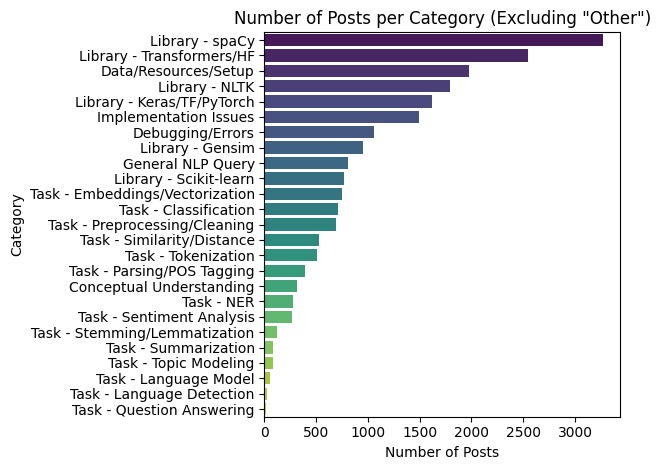

Displayed bar chart of category counts.


In [36]:
counts_to_plot = category_counts[category_counts.index != 'Other/Uncategorized']
if not counts_to_plot.empty:
    sns.barplot(x=counts_to_plot.values, y=counts_to_plot.index, palette="viridis")
    plt.title('Number of Posts per Category (Excluding "Other")')
    plt.xlabel('Number of Posts')
    plt.ylabel('Category')
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
    print("Displayed bar chart of category counts.")
else:
    print("No categories (excluding 'Other') to plot.")

In [37]:
# Configuration
EXCEL_FILE_PATH = '/content/stackoverflow_nlp_data.xlsx'
NEW_CATEGORIZED_SHEET_NAME = 'Categorized_Posts_Simple'

ORIGINAL_COLUMNS = ['title', 'description', 'accepted_answer', 'tags_str']
CATEGORY_COLUMN = 'category'

if 'df' in locals() and 'df_processed' in locals():
    if all(col in df.columns for col in ORIGINAL_COLUMNS) and CATEGORY_COLUMN in df_processed.columns:
        # Select required columns and combine
        df_to_write = df[ORIGINAL_COLUMNS].copy()
        # Add category column - assumes indices align
        df_to_write[CATEGORY_COLUMN] = df_processed[CATEGORY_COLUMN]

        # Write to Excel
        with pd.ExcelWriter(EXCEL_FILE_PATH,
                            engine='openpyxl',
                            mode='a',
                            if_sheet_exists='replace') as writer:
            df_to_write.to_excel(writer, sheet_name=NEW_CATEGORIZED_SHEET_NAME, index=False)

        print(f"Successfully wrote data to sheet.")
    else:
        print("Required columns not found in DataFrames.")
else:
    print("Ensure 'df' and 'df_processed' DataFrames are loaded.")


Successfully wrote data to sheet.
